# Prediction of out-of-tolerance risk due to drift over calibration interval

In this example, a pressure gauge has been calibrated 5 times and shows predictable drift. As the value is drifting nearer the out-of-tolerance limit, a decision needs to be made on whether to adjust the gauge or not based on the probability of an OOT on the next calibration date.

This analysis uses both the Curve-Fit and the Risk functions of the PSL uncertainty calculator.


In [7]:
import numpy as np
from scipy import stats
from dateutil.parser import parse
import matplotlib.pyplot as plt

from suncal import curvefit, risk

## Fit the drift curve

First, a line is fit to the previous 5 calibrated values to determine the drift rate and predict a value and uncertainty at the time of the next calibration cycle. In this example, the raw measurements are entered directly in the notebook. The datestamps are converted to ordinal time before being put into the curve-fit array. They could be loaded from a file (see np.genfromtxt with the `converters` parameter for converting dates).

In [8]:
x = np.array([parse(i).toordinal() for i in ['6-Nov-2011', '7-Oct-2013', '1-Aug-2015', '23-Jul-2016', '11-May-2018']])
psi = np.array([180.1, 181.5, 182.2, 183.0, 184.0])
upsi = 0.2

arr = curvefit.Array(x, psi, uy=upsi)

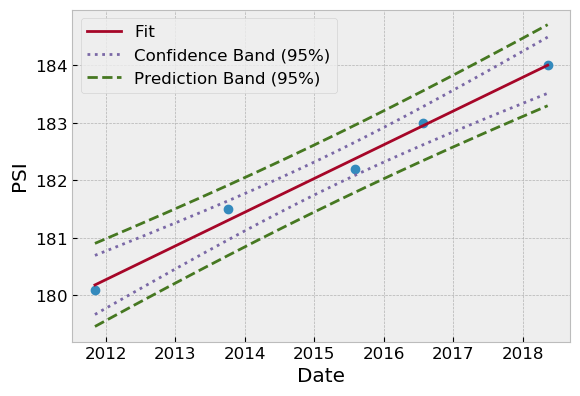

In [9]:
# Run the fit, least-squares method. Specify xdates parameter so ordinal values are plotted as dates.
fit = curvefit.CurveFit(arr, xdates=True)
fit.xname = 'Date'  # To label plot axes
fit.yname = 'PSI'
out = fit.calc_LSQ()
out.plot_summary(conf=.95);

In [10]:
# Predict the value on 1-Jul-2019
nextcaldate = parse('1-Jul-2019').toordinal()
predicted_val = out.y(nextcaldate)
predicted_unc = out.u_pred(nextcaldate, conf=.95)
print('{:.2f} +/- {:.2f} (95%)'.format(predicted_val, predicted_unc))

184.67 +/- 0.79 (95%)


## Determine OOT risk

It is clear the 95% probability range can fall above 185. Now, the Risk module is used to determine the actual probability that this prediction band distribution will fall outside the limit of 175-185 psi on the next calibration date.

In [11]:
pred_dist = out.u_pred_dist(nextcaldate)  # Get scipy.stats distribution (this will be student-t)

cpk, OOTrisk, _, _ = risk.specific_risk(pred_dist, LL=175, UL=185)
print('Risk of OOT: {:.2f}%'.format(OOTrisk*100))

Risk of OOT: 5.24%


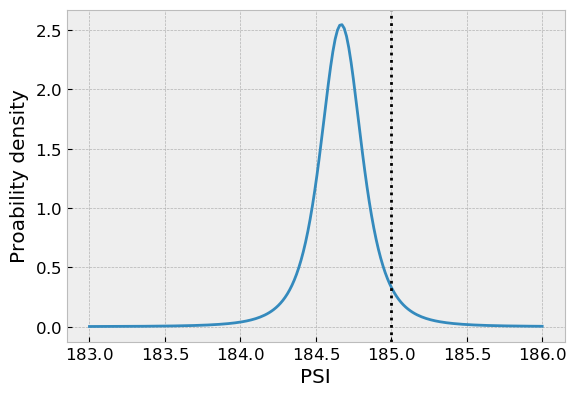

In [12]:
# To see the distribution graphically
xx = np.linspace(183, 186, num=200)
plt.plot(xx, pred_dist.pdf(xx))
plt.axvline(185, ls=':', color='black');
plt.xlabel('PSI')
plt.ylabel('Proability density');

It is up to the metrologist to determine whether this level of risk warrants an adjustment to the gauge.